# Metabolism Questions

## Debug

In [2]:
from cobra.io import load_matlab_model
import os


In [9]:
k12fam = [f for f in os.listdir("/Mounts/rbg-storage1/datasets/Metabo/BiGG") if "K-12" in f]

In [10]:
k12fam

[]

In [11]:
model = load_matlab_model("/Mounts/rbg-storage1/datasets/Metabo/BiGG/iML1515.mat")

This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model iML1515. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, p


Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


In [24]:
reactions = model.reactions

In [25]:
reactions[271]

Reaction identifier,EDTXS3
Name,Endotoxin Synthesis (palmitoleoyl ACP)
Memory address,0x7efdbbb96dc0
Stoichiometry,hdeACP_c + kdo2lipid4_c --> ACP_c + kdo2lipid4p_c Cis-hexadec-9-enoyl-[acyl-carrier protein] (n-C16:1) + KDO(2)-lipid IV(A) --> Acyl carrier protein + KDO(2)-lipid IV(A) with palmitoleoyl
GPR,b2378
Lower bound,0.0
Upper bound,1000.0


In [ ]:
biocyc = [f for f in db_meta.values[0].split(";") if "biocyc" in f]

In [ ]:
db_meta = BIGG_METABOLITES[BIGG_METABOLITES["bigg_id"] == metabolite.id][
        "database_links"
    ]

# Datasets

In [40]:
from collections import defaultdict
import time
import pandas as pd
import numpy as np
from scipy.io import loadmat
# import escher
# from escher import Builder
import cobra
from cobra.io import load_matlab_model, load_json_model, save_json_model, load_model
# import cobramod
import json, copy
import os
from xml.etree import cElementTree as ET
from tqdm import tqdm
import re
import copy
import requests
from cobra.core.metabolite import Metabolite
from bioservices import ChEBI
import warnings

In [41]:
def xml2dict(t):
    d = {}
    children = list(t)
    if children:
        dd = defaultdict(list)
        for dc in map(xml2dict, children):
            for k, v in dc.items():
                if (not k == "") and not ("reference" in k):
                    dd[k.split("}")[-1]].append(v)
        d = {
            t.tag.split("}")[-1]: {
                k.split("}")[-1]: v[0] if len(v) == 1 else v for k, v in dd.items()
            }
        }

    if t.text:
        text = t.text.strip()
        if (not text == "") and not ("reference" in text):
            d[t.tag] = text
    return d

Outstanding questions:
- Experimental val
- Link to drug: drugbank to target id
- Link to disease (kg): Get disease ids from json; API to download individual diseases; biopython kgml to parse
- Link to drug screen db (depmap, cmap): 


for masking:
    data is: mini-pathways 
for gap filling: 
    network -> growth/no growth
for flux:
    network -> edge labels

validate reaction? 

```
Data Structure:
    {
        "metabolites": {},  # id to metadata
        "drugs": {},        # id to metadata
        "proteins": {},     # id to metadata
        "reactions": {}, 
        "pathways/groups" ?
        "network" ? 
    }
```


- Use cobrapy with BiGG models 
- Use cobramod to get KEGG if need be
- BioPython integrate other databases

------------
TODO:

- [ ] Get list of pathways per organism
- [ ] Programmatically make pathways and add to model
- [ ] Save as mat files
- [ ] Make drugbank and hmdb metadata files


# KEGG


- KEGG NETWORK represents a renewed attempt by KEGG to capture knowledge of diseases and drugs in terms of perturbed molecular networks

: Metabolic pathways -> individual pathways and reactions

```
pathway
|
|-- module
|    |
|    |-- reactions
```

In [4]:
from cobramod import create_object
from pathlib import Path
from cobramod.parsing.kegg import retrieve_data
from cobramod import get_data
import cobramod
from cobra import Model

In [13]:
# Using copy of test model
test_model = Model('test_model')

In [48]:
newobj= retrieve_data(
    directory = Path.cwd().resolve().joinpath("tempdir"),
    identifier="hsa05210")  # M00051

In [49]:
newobj

{'ENTRY': ['hsa05210                    Pathway'],
 'NAME': ['Colorectal cancer - Homo sapiens (human)'],
 'DESCRIPTION': ['Colorectal cancer (CRC) is the second largest cause of cancer-related deaths in Western countries. CRC arises from the colorectal epithelium as a result of the accumulation of genetic alterations in defined oncogenes and tumour suppressor genes (TSG). Two major mechanisms of genomic instability have been identified in sporadic CRC progression. The first, known as chromosomal instability (CIN), results from a series of genetic changes that involve the activation of oncogenes such as K-ras and inactivation of TSG such as p53, DCC/Smad4, and APC. The second, known as microsatellite instability (MSI), results from inactivation of the DNA mismatch repair genes MLH1 and/or MSH2 by hypermethylation of their promoter, and secondary mutation of genes with coding microsatellites, such as transforming growth factor receptor II (TGF-RII) and BAX. Hereditary syndromes have ger

# Escher

In [ ]:

"""
gen_map() passing the Cobra model, a list of
the reactions you wish to include and a list of metabolites you do
not wish to be used to create links between reactions (e.g. ATP). This
returns an EscherMap object. Use map_obj.dump_json() to get a JSON that
can be passed to escher.Builder()
"""
import sys
sys.path.append("escher_helper")
from escher_helper.generate_escher_map import gen_map

recon3 = load_matlab_model('/Mounts/rbg-storage1/datasets/Metabo/Recon3D/Recon3D_301/Recon3D_301.mat')

reactions_of_interest = list(recon3.groups[0].members)
metabolites_of_interest = list(set([l.id for m in recon3.groups[0].members for l in list(m.metabolites.keys())]))
bldr = gen_map(recon3,  reactions_of_interest, metabolites_of_interest)

---------------------------
# HMDB (Done)

In [11]:
metabolites_db = json.load(open("/Mounts/rbg-storage1/datasets/Metabo/HMDB/metabolites.json", 'r'))

In [6]:
protein_db = json.load(open("/Mounts/rbg-storage1/datasets/Metabo/HMDB/proteins.json", 'r'))

# Drug Bank (To Parse)

In [5]:
import pandas as pd
import json

In [ ]:
protein_db = json.load(open("/Mounts/rbg-storage1/datasets/Metabo/HMDB/proteins.json", 'r'))

In [9]:
protein_db['HMDBP00473']

'HMDBP00473'

In [10]:
# enzymes that are targets
targets = pd.read_csv("/Mounts/rbg-storage1/users/pgmikhael/DrugBank/drugbank_all_target_polypeptide_ids/all.csv")
enzymes = pd.read_csv("/Mounts/rbg-storage1/users/pgmikhael/DrugBank/drugbank_all_enzyme_polypeptide_ids/all.csv")
approved = pd.read_csv("/Mounts/rbg-storage1/users/pgmikhael/DrugBank/drugbank_approved_target_polypeptide_ids/all.csv")

targets_as_enzymes = [ t for t in set(targets['UniProt ID']) if t in set(enzymes['UniProt ID'])]
approved_targets_as_enzymes = [ t for t in targets_as_enzymes if t in set(approved['UniProt ID'])]

summary = "Targets that are enzymes: {}, Found in HMDB: {} \
\nTargets that are enzymes for approved drugs: {}, Found in HMDB: {}"

# print( 
#     summary.format(
#     len(targets_as_enzymes), len([t for t in targets_as_enzymes if hmdb_to_uniprot.get(t, False) ]),
#     len(approved_targets_as_enzymes), len([t for t in approved_targets_as_enzymes if hmdb_to_uniprot.get(t, False) ]))
# )

In [42]:
enzymes[enzymes['Species'] == "Escherichia coli"]

,ID,Name,Gene Name,GenBank Protein ID,GenBank Gene ID,UniProt ID,Uniprot Title,PDB ID,GeneCard ID,GenAtlas ID,HGNC ID,Species,Drug IDs
209,1542,Chloramphenicol acetyltransferase 3,cat3,47025.0,X07848,P00484,CAT3_ECOLX,1CIA; 1CLA; 1QCA; 2CLA; 3CLA; 4CLA,NaN,NaN,NaN,Escherichia coli,DB00446; DB07565
215,2015,Beta-lactamase SHV-1,bla,5002312.0,AF148850,P0AD63,BLA1_ECOLX,NaN,NaN,NaN,NaN,Escherichia coli,DB01598
287,9851,Beta-lactamase,NaN,NaN,NaN,Q939N4,Q939N4_ECOLX,1YLW,NaN,NaN,NaN,Escherichia coli,DB01598
288,9854,Beta-lactamase,blaCTX-M-14,NaN,NaN,Q9L5C7,Q9L5C7_ECOLX,1YLT; 1YLY; 1YLZ; 4XXR; 5TW6; 5TWD; 5TWE; 5VTH...,NaN,NaN,NaN,Escherichia coli,DB01598
289,9857,Beta-lactamase,blaCTX-M-27,NaN,NaN,Q840M4,Q840M4_ECOLX,1YLP,NaN,NaN,NaN,Escherichia coli,DB01598
312,3548,Aminoglycoside 3'-phosphotransferase,aphA1,43026.0,V00359,P00551,KKA1_ECOLX,NaN,NaN,NaN,NaN,Escherichia coli,DB01172
341,3894,Beta-lactamase TEM,bla,208959.0,J01749,P62593,BLAT_ECOLX,1AXB; 1BT5; 1BTL; 1CK3; 1ERM; 1ERO; 1ERQ; 1ESU...,NaN,NaN,NaN,Escherichia coli,DB01053; DB01598


In [94]:
import json

In [95]:
ecoli_model = json.load(open("/Mounts/rbg-storage1/datasets/Metabo/datasets/iML1515_dataset.json", "r"))

In [34]:
ecoli_model[0]['proteins'][0]['protein_sequence']

'MTDQSHQCVIIGIAGASASGKSLIASTLYRELREQVGDEHIGVIPEDCYYKDQSHLSMEERVKTNYDHPSAMDHSLLLEHLQALKRGSAIDLPVYSYVEHTRMKETVTVEPKKVIILEGILLLTDARLRDELNFSIFVDTPLDICLMRRIKRDVNERGRSMDSVMAQYQKTVRPMFLQFIEPSKQYADIIVPRGGKNRIAIDILKAKISQFFE'

In [26]:
ecoli_proteins = [ 
    uniprot['id'] 
    for rxn_dict in ecoli_model for protein_dict in rxn_dict['proteins'] for uniprot in protein_dict['database_links'].get('UniProt', [{'id':None}])
]
ecoli_proteins = list(set(ecoli_proteins))

In [35]:
ecoli_protein_seqs = [ 
    protein_dict['protein_sequence']
    for rxn_dict in ecoli_model for protein_dict in rxn_dict['proteins'] 
]
ecoli_protein_seqs = list(set(ecoli_protein_seqs))

In [36]:
len(ecoli_protein_seqs)

1514

In [ ]:
ecoli_proteins = [ 
    uniprot['id'] 
    for rxn_dict in ecoli_model for protein_dict in rxn_dict['proteins'] for uniprot in protein_dict['database_links'].get('UniProt', [{'id':None}])
]
ecoli_proteins = list(set(ecoli_proteins))

In [31]:
seq = "MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW"

In [39]:
set(ecoli_proteins).intersection(set(targets_as_enzymes))

{'P46883'}

In [47]:
chembl_targets = pd.read_csv("chembl_ecoli_targets.csv", delimiter = ";")

In [61]:
set(ecoli_proteins).intersection(set(list(chembl_targets['UniProt Accessions'])))

{'P00946',
 'P04036',
 'P05793',
 'P05804',
 'P06988',
 'P08192',
 'P0A6F3',
 'P0A6I6',
 'P0A6X1',
 'P0A720',
 'P0A752',
 'P0A7E9',
 'P0A8F0',
 'P0A955',
 'P0A9M5',
 'P0A9P4',
 'P0ABF8',
 'P0ACB2',
 'P0ACC7',
 'P0AD57',
 'P17443',
 'P22188',
 'P24173',
 'P26281',
 'P26616',
 'P26647',
 'P41052',
 'P60472',
 'P60546',
 'P60932',
 'P62615',
 'P62617',
 'P76558',
 'P77364',
 'P77488',
 'Q6BF16'}

In [58]:
chembl_all_targets = pd.read_csv("chembl_targets.csv", delimiter = ";")

In [59]:
len(set(ecoli_proteins).intersection(set(list(chembl_all_targets['UniProt Accessions']))))

92

In [60]:
set(ecoli_proteins).intersection(set(list(chembl_all_targets['UniProt Accessions'])))

{'P00634',
 'P00722',
 'P00946',
 'P02918',
 'P02919',
 'P02930',
 'P04036',
 'P04825',
 'P05194',
 'P05793',
 'P05804',
 'P06720',
 'P06721',
 'P06987',
 'P06988',
 'P07003',
 'P07639',
 'P07650',
 'P07862',
 'P08192',
 'P08373',
 'P0A6A8',
 'P0A6B4',
 'P0A6D3',
 'P0A6F3',
 'P0A6I3',
 'P0A6I6',
 'P0A6L2',
 'P0A6R0',
 'P0A6W3',
 'P0A6X1',
 'P0A720',
 'P0A722',
 'P0A725',
 'P0A749',
 'P0A752',
 'P0A7E9',
 'P0A884',
 'P0A8F0',
 'P0A953',
 'P0A955',
 'P0A9C5',
 'P0A9J4',
 'P0A9J6',
 'P0A9J8',
 'P0A9M5',
 'P0A9P4',
 'P0AB71',
 'P0AB98',
 'P0ABF8',
 'P0ABQ4',
 'P0AC13',
 'P0ACB2',
 'P0ACC7',
 'P0AD57',
 'P0AD65',
 'P0ADG7',
 'P0AEG4',
 'P0AEJ2',
 'P0AEK4',
 'P0AEX9',
 'P0AEY8',
 'P0AG20',
 'P10378',
 'P10384',
 'P11880',
 'P13738',
 'P14900',
 'P17443',
 'P17952',
 'P22188',
 'P22939',
 'P24173',
 'P26281',
 'P26616',
 'P26647',
 'P28305',
 'P31224',
 'P37747',
 'P38489',
 'P41052',
 'P45568',
 'P45578',
 'P60472',
 'P60546',
 'P60932',
 'P62615',
 'P62617',
 'P76558',
 'P77364',
 'P77488',

In [62]:
ecoli_proteins[0]

'P77268'

In [ ]:
page = requests.get(
    f"https://websvc.biocyc.org/getxml?id={biocycid}&detail=full"
)

In [ ]:
https://pubchem.ncbi.nlm.nih.gov/rest/pug/assay/aid/490/targets/PP77268/XML

In [ ]:
# BioAssay:
prolog = "https://pubchem.ncbi.nlm.nih.gov/rest/pug"
input = "assay/aid/{id}"
operation = "/description"
output = "/XML"

#### pubchem

In [ ]:
import pubchempy
import requests
# https://pubchemdocs.ncbi.nlm.nih.gov/pug-rest-tutorial

In [66]:
# get protein information
protein_id = "P77268"
pg = requests.get(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/protein/accession/{protein_id}/summary/JSON").json()

In [67]:
pg

{'ProteinSummaries': {'ProteinSummary': [{'ProteinAccession': 'P77268',
    'Name': 'Probable D,D-dipeptide transport ATP-binding protein DdpD',
    'TaxonomyID': 83333,
    'Taxonomy': 'Escherichia coli K-12'}]}}

In [84]:
# get assay information
aid = "1146827"
rs = requests.get(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/assay/aid/{aid}/concise/JSON").json()

In [85]:
rs

{'Table': {'Columns': {'Column': ['AID',
    'SID',
    'CID',
    'Activity Outcome',
    'Target Accession',
    'Target GeneID',
    'Activity Value [uM]',
    'Activity Name',
    'Assay Name',
    'Assay Type',
    'PubMed ID',
    'RNAi']},
  'Row': [{'Cell': ['1146827',
     '242644934',
     '12376153',
     'Inactive',
     'P00634',
     '',
     '',
     '',
     'Inhibition of Escherichia coli alkaline phosphatase assessed as p-nitrophenol formation using p-nitrophenyl phosphate as substrate up to 100 uM treated 15 mins prior to substrate addition by spectrophotometric analysis',
     'Other',
     '333114',
     '']},
   {'Cell': ['1146827',
     '242644935',
     '12376152',
     'Inactive',
     'P00634',
     '',
     '',
     '',
     'Inhibition of Escherichia coli alkaline phosphatase assessed as p-nitrophenol formation using p-nitrophenyl phosphate as substrate up to 100 uM treated 15 mins prior to substrate addition by spectrophotometric analysis',
     'Other',
  

#### chembl

In [1]:
import sqlite3

In [2]:
chembl_path = "/Mounts/rbg-storage1/datasets/ChEMBL/chembl_31/chembl_31_sqlite/chembl_31.db"

In [3]:
conn = sqlite3.connect(chembl_path)

In [6]:
cursor = conn.cursor()

In [95]:
cursor.execute("""SELECT name FROM sqlite_master WHERE type='table';""")

In [96]:
print(cursor.fetchall())

[('action_type',), ('assay_type',), ('chembl_id_lookup',), ('confidence_score_lookup',), ('curation_lookup',), ('source',), ('relationship_type',), ('target_type',), ('variant_sequences',), ('bioassay_ontology',), ('data_validity_lookup',), ('activity_smid',), ('activity_stds_lookup',), ('assay_classification',), ('atc_classification',), ('bio_component_sequences',), ('component_sequences',), ('protein_classification',), ('domains',), ('go_classification',), ('structural_alert_sets',), ('products',), ('frac_classification',), ('hrac_classification',), ('irac_classification',), ('research_stem',), ('organism_class',), ('patent_use_codes',), ('protein_family_classification',), ('usan_stems',), ('version',), ('cell_dictionary',), ('docs',), ('target_dictionary',), ('tissue_dictionary',), ('molecule_dictionary',), ('activity_supp',), ('component_class',), ('component_domains',), ('component_go',), ('component_synonyms',), ('structural_alerts',), ('defined_daily_dose',), ('product_patents',

In [79]:
cursor.execute("""SELECT * from component_synonyms""")

In [80]:
list(map(lambda x: x[0], cursor.description))

['compsyn_id', 'component_id', 'component_synonym', 'syn_type']

In [ ]:
# get chemblid from uniprot
cursor.execute("""SELECT * FROM target_dictionary td
INNER JOIN  target_components tc on td.tid=tc.tid
INNER JOIN component_sequences cseq on tc.component_id=cseq.component_id
AND cseq.accession='P0A7Y4';""")
cursor.fetchall()

In [130]:
# get chemblid from uniprot
uniprots = ('P0A7Y4','P06612')
cursor.execute(f"""SELECT chembl_id FROM target_dictionary td
INNER JOIN  target_components tc on td.tid=tc.tid
INNER JOIN component_sequences cseq on tc.component_id=cseq.component_id
AND cseq.accession IN {uniprots};""")
cursor.fetchall()

[('CHEMBL1770039',), ('CHEMBL3259513',)]

In [47]:
chmbl_targets = ('CHEMBL1827', 'CHEMBL1827')
cmd = f"""SELECT m.chembl_id AS compound_chembl_id,
s.canonical_smiles,
r.compound_key,
a.description                   AS assay_description,
act.standard_type,
act.standard_relation,
act.standard_value,
act.standard_units,
act.activity_comment,
t.chembl_id                    AS target_chembl_id,
t.pref_name                    AS target_name,
t.organism                     AS target_organism
FROM compound_structures s
  JOIN molecule_dictionary m ON s.molregno = m.molregno
  JOIN compound_records r ON m.molregno = r.molregno
  JOIN docs d ON r.doc_id = d.doc_id
  JOIN activities act ON r.record_id = act.record_id
  JOIN assays a ON act.assay_id = a.assay_id
  JOIN target_dictionary t ON a.tid = t.tid
    AND t.chembl_id IN {chmbl_targets}
    AND act.standard_type = 'IC50'
    AND act.standard_units = 'nM';"""

In [48]:
cursor.execute(cmd)

In [49]:
comps = cursor.fetchall()

In [50]:
len(comps)

2322

In [27]:
comps

[('CHEMBL1770692',
  'CC(C)(O)[C@H]1CC[C@@](C)(O[C@H]2O[C@@H](CO)[C@H](O)[C@@H](O)[C@@H]2O)[C@H](O)C1',
  '1, distyloside A',
  'Inhibition of Escherichia coli recombinant ribonuclease H after 30 mins by FRET quenching assay',
  'IC50',
  '>',
  20000,
  'nM',
  None,
  'CHEMBL1770039',
  'Ribonuclease HI',
  'Escherichia coli (strain K12)'),
 ('CHEMBL1770693',
  'CC(C)(O)[C@H]1CC=C(CO[C@H]2O[C@@H](CO[C@H]3OC[C@H](O)[C@@H](O)[C@@H]3O)[C@H](O)[C@@H](O)[C@@H]2O)CC1',
  '2, distyloside B',
  'Inhibition of Escherichia coli recombinant ribonuclease H after 30 mins by FRET quenching assay',
  'IC50',
  '>',
  20000,
  'nM',
  None,
  'CHEMBL1770039',
  'Ribonuclease HI',
  'Escherichia coli (strain K12)'),
 ('CHEMBL1770694',
  'C[C@H](O)CC[C@@]1(O)[C@@H](C)C[C@H](O[C@H]2O[C@@H](CO)[C@H](O)[C@@H](O)[C@@H]2O)CC1(C)C',
  '3',
  'Inhibition of Escherichia coli recombinant ribonuclease H after 30 mins by FRET quenching assay',
  'IC50',
  '>',
  20000,
  'nM',
  None,
  'CHEMBL1770039',
  'Ribon

In [2]:
proteins = []
with open("protein.fasta", "r") as f:
    for line in f:
        if line.startswith("HMDBP"):
            proteins.append(line.split(' ')[0])

In [3]:
len(proteins)

5629

In [46]:
drugbank_levels = defaultdict(list)

n = 0
level = 0
entries = 0
start_time = time.time()
for event, elem in ET.iterparse('../DrugBank/drugbank.xml', events=('start', 'end') ):
    if event == 'start':
        level += 1
        if elem.tag.split('}')[-1] not in drugbank_levels[f"l{level}"]:
            drugbank_levels[f"l{level}"].append(elem.tag.split('}')[-1])
        if level == 2:
            entries += 1
    
    if event == 'end':
        level -= 1


    if n % 10e6 == 0:
        mins = round((time.time() - start_time)/60, 4)
        print("Processed {} entries in {} minutes".format(entries, mins))
    
    n+=1

Processed 0 entries in 0.0001 minutes
Processed 528 entries in 0.391 minutes
Processed 1024 entries in 0.757 minutes
Processed 3929 entries in 1.1797 minutes
Processed 8221 entries in 1.5274 minutes
Processed 10415 entries in 1.8946 minutes


In [48]:
drugbank_levels

defaultdict(list,
            {'l1': ['drugbank'],
             'l2': ['drug'],
             'l3': ['drugbank-id',
              'name',
              'description',
              'cas-number',
              'unii',
              'state',
              'groups',
              'general-references',
              'synthesis-reference',
              'indication',
              'pharmacodynamics',
              'mechanism-of-action',
              'toxicity',
              'metabolism',
              'absorption',
              'half-life',
              'protein-binding',
              'route-of-elimination',
              'volume-of-distribution',
              'clearance',
              'classification',
              'salts',
              'synonyms',
              'products',
              'international-brands',
              'mixtures',
              'packagers',
              'manufacturers',
              'prices',
              'categories',
              'affected-organisms',
 

# BiGG Models

In [49]:
model = load_matlab_model(f"/Mounts/rbg-storage1/datasets/Metabo/BiGG/e_coli_core.mat")

This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model e_coli_core. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


In [50]:
model

Name,e_coli_core
Memory address,0x07f11a09ebf70
Number of metabolites,72
Number of reactions,95
Number of groups,11
Objective expression,1.0*BIOMASS_Ecoli_core_w_GAM - 1.0*BIOMASS_Ecoli_core_w_GAM_reverse_712e5
Compartments,"e, c"


In [51]:
val, = model.groups[0].members[0].genes

In [52]:
val

Gene identifier,b3956
Name,
Memory address,0x7f11a0a006d0
Functional,True
In 1 reaction(s),PPC


In [ ]:
metabolite2pathway = {}
for pathway in model.groups:
    for reaction in pathway.members:
        for metabolite in reaction.metabolites:
            metabolite2pathway.setdefault(metabolite.id, set())
            metabolite2pathway[metabolite.id].add(pathway.id)

In [ ]:
sorted({(k, len(v)) for k,v in metabolite2pathway.items()}, key=lambda x: x[1], reverse=True)

72

In [ ]:
from bioservices import UniProt

In [6]:
u = UniProt()

In [14]:
u.mapping("P_ENTREZGENEID", "ACC", query='314')

defaultdict(list, {'314': ['O75106']})

In [15]:
df = u.get_df(['O75106'])

/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/fba/lib/python3.10/site-packages/bioservices/uniprot.py:812: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(df, ignore_index=True)


In [13]:
pd.set_option('display.max_columns', None)
df[(df['Entry'] == 'Q9UJ70') | (df['Entry'] == 'A0A384N6G7') | (df['Entry'] ==  'C9JEV6')]

,Entry,Entry name,Gene names,Gene names (primary ),Gene names (synonym ),Gene names (ordered locus ),Gene names (ORF ),Organism,Organism ID,Protein names,Proteomes,Taxonomic lineage (ALL),Taxonomic lineage IDs,Virus hosts,Fragment,Sequence,Length,Mass,Gene encoded by,Alternative products (isoforms),Erroneous gene model prediction,Erroneous initiation,Erroneous termination,Erroneous translation,Frameshift,Mass spectrometry,Polymorphism,RNA editing,Sequence caution,Alternative sequence,Natural variant,Non-adjacent residues,Non-standard residue,Non-terminal residue,Sequence conflict,Sequence uncertainty,Version (sequence),Domains,Domain count,Domain [CC],Sequence similarities,Coiled coil,Compositional bias,Domain [FT],Motif,Region,Repeat,Zinc finger,EC number,Absorption,Catalytic activity,Cofactor,Function [CC],Kinetics,Pathway,Redox potential,Temperature dependence,pH dependence,Active site,Binding site,DNA binding,Metal binding,Nucleotide binding,Site,Gene ontology (GO),Gene ontology (biological process),Gene ontology (molecular function),Gene ontology (cellular component),Gene ontology IDs,InterPro,Interacts with,Subunit structure [CC],PubMed ID,Mapped PubMed ID,Date of creation,Date of last modification,Date of last sequence modification,Version (entry),3D,Beta strand,Helix,Turn,Subcellular location [CC],Intramembrane,Topological domain,Transmembrane,Annotation,Features,Caution,Tissue specificity,Miscellaneous [CC],Keywords,Protein existence,Status,Sequence annotation (Features),Protein families,Version,Comments,Cross-reference (null),Keyword ID,Pathway.1,Allergenic properties,Biotechnological use,Disruption phenotype,Involvement in disease,Pharmaceutical use,Toxic dose,Post-translational modification,Chain,Cross-link,Disulfide bond,Glycosylation,Initiator methionine,Lipidation,Modified residue,Peptide,Propeptide,Signal peptide,Transit peptide,Taxonomic lineage (all),Taxonomic lineage (SUPERKINGDOM),Taxonomic lineage (KINGDOM),Taxonomic lineage (SUBKINGDOM),Taxonomic lineage (SUPERPHYLUM),Taxonomic lineage (PHYLUM),Taxonomic lineage (SUBPHYLUM),Taxonomic lineage (SUPERCLASS),Taxonomic lineage (CLASS),Taxonomic lineage (SUBCLASS),Taxonomic lineage (INFRACLASS),Taxonomic lineage (SUPERORDER),Taxonomic lineage (ORDER),Taxonomic lineage (SUBORDER),Taxonomic lineage (INFRAORDER),Taxonomic lineage (PARVORDER),Taxonomic lineage (SUPERFAMILY),Taxonomic lineage (FAMILY),Taxonomic lineage (SUBFAMILY),Taxonomic lineage (TRIBE),Taxonomic lineage (SUBTRIBE),Taxonomic lineage (GENUS),Taxonomic lineage (SUBGENUS),Taxonomic lineage (SPECIES GROUP),Taxonomic lineage (SPECIES SUBGROUP),Taxonomic lineage (SPECIES),Taxonomic lineage (SUBSPECIES),Taxonomic lineage (VARIETAS),Taxonomic lineage (FORMA),Taxonomic lineage IDs (all),Taxonomic lineage IDs (SUPERKINGDOM),Taxonomic lineage IDs (KINGDOM),Taxonomic lineage IDs (SUBKINGDOM),Taxonomic lineage IDs (SUPERPHYLUM),Taxonomic lineage IDs (PHYLUM),Taxonomic lineage IDs (SUBPHYLUM),Taxonomic lineage IDs (SUPERCLASS),Taxonomic lineage IDs (CLASS),Taxonomic lineage IDs (SUBCLASS),Taxonomic lineage IDs (INFRACLASS),Taxonomic lineage IDs (SUPERORDER),Taxonomic lineage IDs (ORDER),Taxonomic lineage IDs (SUBORDER),Taxonomic lineage IDs (INFRAORDER),Taxonomic lineage IDs (PARVORDER),Taxonomic lineage IDs (SUPERFAMILY),Taxonomic lineage IDs (FAMILY),Taxonomic lineage IDs (SUBFAMILY),Taxonomic lineage IDs (TRIBE),Taxonomic lineage IDs (SUBTRIBE),Taxonomic lineage IDs (GENUS),Taxonomic lineage IDs (SUBGENUS),Taxonomic lineage IDs (SPECIES GROUP),Taxonomic lineage IDs (SPECIES SUBGROUP),Taxonomic lineage IDs (SPECIES),Taxonomic lineage IDs (SUBSPECIES),Taxonomic lineage IDs (VARIETAS),Taxonomic lineage IDs (FORMA),Cross-reference (db_abbrev),Cross-reference (EMBL)
0,Q9UJ70,NAGK_HUMAN,[NAGK],NAGK,NaN,NaN,NaN,Homo sapiens (Human),9606,N-acetyl-D-glucosamine kinase (N-acetylglucosa...,UP000005640: Chromosome 2,"cellular organisms, Eukaryota, Opisthokonta, M...",9606,NaN,NaN,MAAIYGGVEGGGTRSEVLLVSEDGKILAEADGLSTNHWL

In [398]:
u.get_fasta_sequence('Q9UJ70')

'MAAIYGGVEGGGTRSEVLLVSEDGKILAEADGLSTNHWLIGTDKCVERINEMVNRAKRKAGVDPLVPLRSLGLSLSGGDQEDAGRILIEELRDRFPYLSESYLITTDAAGSIATATPDGGVVLISGTGSNCRLINPDGSESGCGGWGHMMGDEGSAYWIAHQAVKIVFDSIDNLEAAPHDIGYVKQAMFHYFQVPDRLGILTHLYRDFDKCRFAGFCRKIAEGAQQGDPLSRYIFRKAGEMLGRHIVAVLPEIDPVLFQGKIGLPILCVGSVWKSWELLKEGFLLALTQGREIQAQNFFSSFTLMKLRHSSALGGASLGARHIGHLLPMDYSANAIAFYSYTFS'

In [3]:
models_json = json.load(
    open("/Mounts/rbg-storage1/datasets/Metabo/BiGG/bigg_models.json", "rb")
)
models = [v["bigg_id"] for v in models_json["results"]]

In [4]:
organism2gene2sequence = {}
genes_without_sequence = [] # these in GEMPro
genes_with_sequence = []

for organism_name in tqdm(models, position=0):
    genes = []
    try:
        model = load_matlab_model(f"/Mounts/rbg-storage1/datasets/Metabo/BiGG/{organism_name}.mat")
    except Exception as e:
        print(e)
        print(f"Failed to load model: {organism_name}")
        continue
    # for gene in tqdm(list(model.genes), position=0, leave=True):
    #     r = requests.get(f"http://bigg.ucsd.edu/api/v2/models/{organism_name}/genes/{gene.id}")
    #     protein_metadata = r.json()
    #     # if gene exists in BiGG Model then add them to `organism2gene2sequence`
    #     if 'protein_sequence' in protein_metadata:
    #         organism2gene2sequence.setdefault(organism_name, {})
    #         # if this gene doesn't exist in this organism's gene2sequence dict, then add it
    #         if gene.id not in organism2gene2sequence[organism_name]:
    #             organism2gene2sequence[organism_name].update({gene.id: protein_metadata['protein_sequence']})
    #         # print(protein_metadata)
    #         # if BiGG Model does not have protein_sequence, then we store this gene to put into GEMPro pipeline
    #         try:
    #             entrez_id = protein_metadata['database_links']['NCBI Entrez Gene'][0]['id']
    #             genes_with_sequence.append(entrez_id)
    #         except:
    #             print("This gene is missing an Entrez ID: ", gene.id)
    #     else:
    #         try:
    #             print("Missing prot seq")
    #             entrez_id = protein_metadata['database_links']['NCBI Entrez Gene'][0]['id']
    #             genes_without_sequence.append(entrez_id)
    #         except:
    #             print("This gene is missing an Entrez ID: ", protein_metadata)

  0%|                                                                                                   | 0/108 [00:00<?, ?it/s]This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model e_coli_core. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


  1%|▊                                                                                          | 1/108 [00:08<15:56,  8.93s/it]No defined compartments in model iAB_RBC_283. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e
  2%|█▋                                                                                         | 2/108 [00:37<36:21, 20.58s/it]This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model iAF1260. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, p
  3%|██▍                                                                                      | 3/108 [03:36<2:42:40, 92.96s/it]This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in mo

Some problem with the model, causing error Some compartments were empty. Check the model!
No COBRA model found at /Mounts/rbg-storage1/datasets/Metabo/BiGG/iCHOv1.mat.
Failed to load model: iCHOv1


This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model iCHOv1_DG44. Compartments will be deduced heuristically using regular expressions.
 17%|██████████████▋                                                                         | 18/108 [33:16<2:25:03, 96.71s/it]No defined compartments in model iCN718. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, p, r


Some problem with the model, causing error Some compartments were empty. Check the model!
No COBRA model found at /Mounts/rbg-storage1/datasets/Metabo/BiGG/iCHOv1_DG44.mat.
Failed to load model: iCHOv1_DG44


 18%|███████████████▍                                                                        | 19/108 [33:53<1:56:44, 78.71s/it]No defined compartments in model iCN900. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e
 19%|████████████████▎                                                                       | 20/108 [36:09<2:20:47, 96.00s/it]This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model iE2348C_1286. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, p
 19%|████████████████▉                                                                      | 21/108 [39:32<3:05:27, 127.91s/it]This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in mo

KeyboardInterrupt: 

In [11]:
genes_with_sequence

[]

In [12]:
genes_without_sequence

[]

In [4]:
from ssbio.pipeline.gempro import GEMPRO

In [101]:
ROOT_DIR = '../gempro/'
PROJECT = 'gempro_missing_genes'
PDB_FILE_TYPE = 'mmtf'

# Create the GEM-PRO project
my_gempro = GEMPRO(gem_name=PROJECT, 
                   root_dir=ROOT_DIR, 
                   genes_list=genes_without_sequence,
                   pdb_file_type=PDB_FILE_TYPE)

NameError: name 'GEMPRO' is not defined

In [ ]:
my_gempro.uniprot_mapping_and_metadata('P_ENTREZGENEID')
print('Missing UniProt mapping: ', my_gempro.missing_uniprot_mapping)

In [ ]:
my_gempro.set_representative_sequence(force_rerun=True)

In [ ]:
print('Missing a representative sequence: ', my_gempro.missing_representative_sequence)

In [ ]:
my_gempro.df_representative_sequences.head()

# Recon3D

## README

Recond3D human metabolism reconstruction


**Metabolites**
- mets: metabolite
- metCharges
- metFormulas
- metSmiles
- metNames
- metHMDBID
- metInChIString
- metKEGGID
- metPubChemID
- metCHEBIID
- metPdMap
- metReconMap

**Reactions**
- rxnConfidenceScores
- rxnNames
- rxns: Reaction names
- rxnNotes
- rxnECNumbers: Enzyme Commission Number (EC Number)
- rxnKEGGID
- rxnCOG: Database of Clusters of Orthologous Genes (COGs)
- rxnKeggOrthology
- rxnReconMap: abbreviation
- rxnReferences

**Genes**
- rxnGeneMat: (13543, 3697) reaction x gene, binary
- genes: List of all genes: A VMH gene ID is composed of the Entrez Gene ID followed by a "." and a number. By default this number is 1. If more than one transcript has been reported in the literature, incremental numbers are given. For the moment, it is not possible to map these transcript identifications to a particular transcript sequence.
- grRules: Gene protein rule
- rules: Gene-reaction association rule in computable form 

**Network**
- S: stoich matrix
- lb: Lower bounds
- ub: Upper bounds
- c: Objective coefficients
- csense: the constraint senses (‘L’ for lower than, ‘G’ - greated than, ‘E’ - equal), for each met
- osense: the objective sense (‘max’ or ‘min’) * .csense
- subSystems

**Other**
- modelID
- description
- version
- PleaseCite

In [6]:
x['Recon3D'][0]

AttributeError: 'numpy.ndarray' object has no attribute 'keys'

In [41]:
x['Recon3D'].dtype.names

('S',
 'mets',
 'b',
 'csense',
 'rxns',
 'lb',
 'ub',
 'c',
 'osense',
 'genes',
 'rules',
 'metCharges',
 'metFormulas',
 'metSmiles',
 'metNames',
 'metHMDBID',
 'metInChIString',
 'metKEGGID',
 'metPubChemID',
 'description',
 'grRules',
 'rxnGeneMat',
 'rxnConfidenceScores',
 'rxnNames',
 'rxnNotes',
 'rxnECNumbers',
 'rxnReferences',
 'rxnKEGGID',
 'subSystems',
 'metCHEBIID',
 'metPdMap',
 'metReconMap',
 'modelID',
 'rxnCOG',
 'rxnKeggOrthology',
 'rxnReconMap',
 'version',
 'PleaseCite')

In [46]:
x['Recon3D'][0,0]['modelID']

array(['Recon3D'], dtype='<U7')

In [38]:
dir(x['Recon3D'][0][0].dtype)

['__bool__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'alignment',
 'base',
 'byteorder',
 'char',
 'descr',
 'fields',
 'flags',
 'hasobject',
 'isalignedstruct',
 'isbuiltin',
 'isnative',
 'itemsize',
 'kind',
 'metadata',
 'name',
 'names',
 'ndim',
 'newbyteorder',
 'num',
 'shape',
 'str',
 'subdtype',
 'type']

In [40]:
x['Recon3D'].dtype.names

('S',
 'mets',
 'b',
 'csense',
 'rxns',
 'lb',
 'ub',
 'c',
 'osense',
 'genes',
 'rules',
 'metCharges',
 'metFormulas',
 'metSmiles',
 'metNames',
 'metHMDBID',
 'metInChIString',
 'metKEGGID',
 'metPubChemID',
 'description',
 'grRules',
 'rxnGeneMat',
 'rxnConfidenceScores',
 'rxnNames',
 'rxnNotes',
 'rxnECNumbers',
 'rxnReferences',
 'rxnKEGGID',
 'subSystems',
 'metCHEBIID',
 'metPdMap',
 'metReconMap',
 'modelID',
 'rxnCOG',
 'rxnKeggOrthology',
 'rxnReconMap',
 'version',
 'PleaseCite')

In [26]:
x['Recon3D'].keys()

AttributeError: 'numpy.ndarray' object has no attribute 'keys'

In [7]:
recon3 = load_matlab_model('/Mounts/rbg-storage1/datasets/Metabo/Recon3D/Recon3D_301/Recon3D_301.mat')

No defined compartments in model Recon3D. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


In [49]:
len(recon3.groups)

111

In [50]:
recon3.groups[0]

<Group Alanine and aspartate metabolism at 0x7f09c3f20af0>

In [51]:
dir(recon3.groups[0])

['KIND_TYPES',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_annotation',
 '_id',
 '_kind',
 '_members',
 '_model',
 '_set_id_with_model',
 'add_members',
 'annotation',
 'id',
 'kind',
 'members',
 'name',
 'notes',
 'remove_members']

In [53]:
recon3.groups[0].members

[<Reaction AGTim at 0x7f09d0543a00>,
 <Reaction AGTix at 0x7f09d0543fa0>,
 <Reaction ARGSS at 0x7f09d051bd30>,
 <Reaction ASNNm at 0x7f09d04aed60>,
 <Reaction ASNS1 at 0x7f09d04aef40>,
 <Reaction ASPNATm at 0x7f09d04b8550>,
 <Reaction ASPTAm at 0x7f09d04b8e80>,
 <Reaction DASPO1p at 0x7f09d03a71f0>,
 <Reaction NACASPAH at 0x7f09cffd8b80>,
 <Reaction RE1473C at 0x7f09cf8e2250>,
 <Reaction RE2031M at 0x7f09cf841a90>,
 <Reaction RE2642C at 0x7f09cb7af700>,
 <Reaction ALAR at 0x7f09cb10e730>,
 <Reaction ASPTA at 0x7f09cb10e850>,
 <Reaction r0127 at 0x7f09cb093c10>,
 <Reaction ARGSL at 0x7f09cb0452b0>]

In [13]:
save_json_model(recon3, "recon3.json")

In [10]:
solution = recon3.optimize()

In [11]:
solution

,fluxes,reduced_costs
10FTHF5GLUtl,0.000000,0.0
10FTHF5GLUtm,0.000000,0.0
10FTHF6GLUtl,0.000000,0.0
10FTHF6GLUtm,0.000000,0.0
10FTHF7GLUtl,0.000000,0.0
...,...,...
CYOR_u10mi,666.666667,0.0
Htmi,0.000000,0.0
NADH2_u10mi,0.000000,0.0
CYOOm3i,333.333333,0.0


In [10]:
save_json_model(textbook_model, "test.json")

In [9]:
textbook_model = load_model("textbook")

In [18]:
model = load_matlab_model('e_coli_core.mat')

This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model e_coli_core. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


In [24]:
model.constraints

In [26]:
from rdkit import Chem, RDLogger
import torch

In [35]:
mol = Chem.MolFromSmiles("CC(O)(P(=O)([O-])O)P(=O)([O-])O.[Na+].[Na+]")

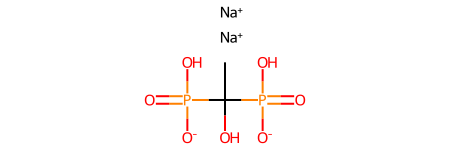

In [36]:
mol

In [26]:
import networkx as nx

In [ ]:
mol

In [44]:
x_map = {
    "atomic_num": list(range(0, 119)),
    "chirality": [
        "CHI_UNSPECIFIED",
        "CHI_TETRAHEDRAL_CW",
        "CHI_TETRAHEDRAL_CCW",
        "CHI_OTHER",
    ],
    "degree": list(range(0, 11)),
    "formal_charge": list(range(-5, 7)),
    "num_hs": list(range(0, 9)),
    "num_radical_electrons": list(range(0, 5)),
    "hybridization": [
        "UNSPECIFIED",
        "S",
        "SP",
        "SP2",
        "SP3",
        "SP3D",
        "SP3D2",
        "OTHER",
    ],
    "is_aromatic": [False, True],
    "is_in_ring": [False, True],
}

e_map = {
    "bond_type": [
        "misc",
        "SINGLE",
        "DOUBLE",
        "TRIPLE",
        "AROMATIC",
    ],
    "stereo": [
        "STEREONONE",
        "STEREOZ",
        "STEREOE",
        "STEREOCIS",
        "STEREOTRANS",
        "STEREOANY",
    ],
    "is_conjugated": [False, True],
}

def from_smiles(smiles: str, with_hydrogen: bool = False, kekulize: bool = False):
    r"""Converts a SMILES string to a :class:`torch_geometric.data.Data`
    instance.
    Args:
        smiles (string, optional): The SMILES string.
        with_hydrogen (bool, optional): If set to :obj:`True`, will store
            hydrogens in the molecule graph. (default: :obj:`False`)
        kekulize (bool, optional): If set to :obj:`True`, converts aromatic
            bonds to single/double bonds. (default: :obj:`False`)
    """

    RDLogger.DisableLog("rdApp.*")

    mol = Chem.MolFromSmiles(smiles)

    if mol is None:
        mol = Chem.MolFromSmiles("")
    if with_hydrogen:
        mol = Chem.AddHs(mol)
    if kekulize:
        mol = Chem.Kekulize(mol)

    xs = []
    for atom in mol.GetAtoms():
        x = []
        x.append(x_map["atomic_num"].index(atom.GetAtomicNum()))
        x.append(x_map["chirality"].index(str(atom.GetChiralTag())))
        x.append(x_map["degree"].index(atom.GetTotalDegree()))
        x.append(x_map["formal_charge"].index(atom.GetFormalCharge()))
        x.append(x_map["num_hs"].index(atom.GetTotalNumHs()))
        x.append(x_map["num_radical_electrons"].index(atom.GetNumRadicalElectrons()))
        x.append(x_map["hybridization"].index(str(atom.GetHybridization())))
        x.append(x_map["is_aromatic"].index(atom.GetIsAromatic()))
        x.append(x_map["is_in_ring"].index(atom.IsInRing()))
        xs.append(x)
        
        #xs.append(atom.GetSymbol())

    x = torch.tensor(xs, dtype=torch.long).view(-1, 9)

    edge_indices, edge_attrs = [], []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        e = []
        e.append(e_map["bond_type"].index(str(bond.GetBondType())))
        e.append(e_map["stereo"].index(str(bond.GetStereo())))
        e.append(e_map["is_conjugated"].index(bond.GetIsConjugated()))

        edge_indices += [[i, j], [j, i]]
        edge_attrs += [e, e]

    edge_index = torch.tensor(edge_indices)
    edge_index = edge_index.t().to(torch.long).view(2, -1)
    edge_attr = torch.tensor(edge_attrs, dtype=torch.long).view(-1, 3)

    if edge_index.numel() > 0:  # Sort indices.
        perm = (edge_index[0] * x.size(0) + edge_index[1]).argsort()
        edge_index, edge_attr = edge_index[:, perm], edge_attr[perm]

    return xs, edge_index, edge_attr, smiles

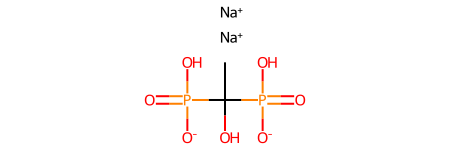

In [45]:
mol

In [46]:
x,e,ef,s = from_smiles("CC(O)(P(=O)([O-])O)P(=O)([O-])O.[Na+].[Na+]")

In [47]:
e

tensor([[ 0,  1,  1,  1,  1,  2,  3,  3,  3,  3,  4,  5,  6,  7,  7,  7,  7,  8,
          9, 10],
        [ 1,  0,  2,  3,  7,  1,  1,  4,  5,  6,  3,  3,  3,  1,  8,  9, 10,  7,
          7,  7]])

In [52]:
edge_to_i = e[1] == 0

In [51]:
edge_from_j = e[0] == 1

In [54]:
torch.where(edge_to_i & edge_from_j)

(tensor([1]),)

In [55]:
def get_reverse_edge_indices(edge_index):
    revedge_index = torch.zeros(edge_index.shape[1]).long()
    for k, (i, j) in enumerate(zip(*edge_index)):
        edge_to_i = edge_index[1] == i
        edge_from_j = edge_index[0] == j
        revedge_index[k] = torch.where(edge_to_i & edge_from_j)[0]
    return revedge_index

In [56]:
get_reverse_edge_indices(e)

tensor([ 1,  0,  5,  6, 13,  2,  3, 10, 11, 12,  7,  8,  9,  4, 17, 18, 19, 14,
        15, 16])

In [39]:
dir(list(mol.GetAtoms())[0])

['ClearProp',
 'DescribeQuery',
 'GetAtomMapNum',
 'GetAtomicNum',
 'GetBonds',
 'GetBoolProp',
 'GetChiralTag',
 'GetDegree',
 'GetDoubleProp',
 'GetExplicitBitVectProp',
 'GetExplicitValence',
 'GetFormalCharge',
 'GetHybridization',
 'GetIdx',
 'GetImplicitValence',
 'GetIntProp',
 'GetIsAromatic',
 'GetIsotope',
 'GetMass',
 'GetMonomerInfo',
 'GetNeighbors',
 'GetNoImplicit',
 'GetNumExplicitHs',
 'GetNumImplicitHs',
 'GetNumRadicalElectrons',
 'GetOwningMol',
 'GetPDBResidueInfo',
 'GetProp',
 'GetPropNames',
 'GetPropsAsDict',
 'GetQueryType',
 'GetSmarts',
 'GetSymbol',
 'GetTotalDegree',
 'GetTotalNumHs',
 'GetTotalValence',
 'GetUnsignedProp',
 'HasOwningMol',
 'HasProp',
 'HasQuery',
 'InvertChirality',
 'IsInRing',
 'IsInRingSize',
 'Match',
 'NeedsUpdatePropertyCache',
 'SetAtomMapNum',
 'SetAtomicNum',
 'SetBoolProp',
 'SetChiralTag',
 'SetDoubleProp',
 'SetExplicitBitVectProp',
 'SetFormalCharge',
 'SetHybridization',
 'SetIntProp',
 'SetIsAromatic',
 'SetIsotope',
 'Set

# EColi

In [70]:
import requests, json, sqlite3, argparse
from p_tqdm import p_map
from collections import defaultdict
import time
from tqdm import tqdm

In [63]:
def get_model_uniprots(metabolic_model):
    proteins = [
        uniprot["id"]
        for rxn_dict in metabolic_model
        for protein_dict in rxn_dict["proteins"]
        for uniprot in protein_dict["database_links"].get("UniProt", [{"id": None}])
    ]
    return tuple(set(proteins))

In [62]:
metabolic_model = json.load(open("/Mounts/rbg-storage1/datasets/Metabo/datasets/iML1515_dataset.json", "r"))

In [64]:
metabolic_proteins = get_model_uniprots(metabolic_model)

In [65]:
metabolic_proteins[:10]

('P17993',
 'P0A8F4',
 'P27833',
 'P40191',
 'Q47142',
 'P0A6X1',
 'P60664',
 'P00926',
 'P0ACE0',
 'P0AE76')

In [66]:
protein_id = 'P17993'
protein_pg = requests.get(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/protein/accession/{protein_id}/aids/JSON").json()

In [67]:
protein_pg

{'Fault': {'Code': 'PUGREST.NotFound',
  'Message': 'No `aids` data found with the given ProteinAccession(s)'}}

In [71]:
results = []
for protein_id in tqdm(metabolic_proteins):
    protein_pg = requests.get(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/protein/accession/{protein_id}/aids/JSON").json()
    results.append(protein_pg)

100%|█████████████████████████████████████████████████████████████████| 1516/1516 [03:26<00:00,  7.33it/s]


In [75]:
requests.get(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/protein/accession/P0AEG4/aids/JSON").json()

{'InformationList': {'Information': [{'ProteinAccession': 'P0AEG4',
    'AID': [1191299,
     1191300,
     1191301,
     1191302,
     1191303,
     1191304,
     1191305,
     1652713,
     1777535,
     1777536,
     1777537,
     1777538,
     1777539]}]}}

In [78]:
len([r for r in results if not r.get('Fault', False)])

96

In [82]:
pubchem_aids = []
for p,d in zip(metabolic_proteins,results):
    if not d.get('Fault', False):
        pubchem_aids.append({p: d["InformationList"]["Information"][0]["AID"]})
    else:
        pubchem_aids.append(None)

In [193]:
len(pubchem_aids)

1516

In [196]:
aids_union = []
for r in pubchem_aids:
    if r is not None:
        aids_union.extend(list(r.values())[0])
aids_union = list(set(aids_union))

In [199]:
aids_union = [str(a) for a in aids_union]
aid_queries = [','.join(aids_union[i:(i+100)]) for i in range(0,len(aids_union), 100)]

In [220]:
aid_queries[0]

'210950,210951,210952,210953,669709,241682,57394,57395,57396,57397,57398,57399,57400,497721,57401,57402,497724,57403,57404,57405,57406,57407,57408,57409,57411,497733,57410,497735,497736,57417,57412,497739,57416,57413,497742,497743,57415,497745,497746,497747,57426,57427,57428,57429,57430,57431,57432,57433,57434,57437,57435,497750,1382487,57414,1100699,1335979,1169517,57418,55413,55414,211064,55415,57419,55416,55417,55418,55419,57420,55420,55421,55422,55423,57421,55424,55426,55427,239752,57422,452743,452749,57423,452750,282786,1257651,381854,381855,243902,381856,579774,579775,381857,381858,1625007,67785,67786,67787,67788,1625008,67789,67790'

In [206]:
def get_pubchem_assays_results(aid):
    compound_pg = requests.get(
        f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/assay/aid/{aid}/concise/JSON"
    ).json()

    columns = compound_pg["Table"]["Columns"]["Column"]
    results = []
    for row in compound_pg["Table"]["Row"]:
        results.append({ colname:row["Cell"][i] for i, colname in enumerate(columns)})
    
    # break up cid queries into 100 chunks
    cid_index = columns.index('CID')
    cids = [row["Cell"][cid_index] for row in compound_pg["Table"]["Row"]]
    cid_queries = [','.join(cids[i:(i+100)]) for i in range(0,len(cids), 100)]
    
    smiles_results = []
    for cid_query in cid_queries:
        smiles_data = requests.get(
            f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid_query}/property/MolecularFormula,MolecularWeight,CanonicalSMILES/JSON"
        ).json()
        smiles_results.extend(smiles_data["PropertyTable"]["Properties"])

    for row, rdict in enumerate(results):
        for key in smiles_results[0].keys():
            rdict[key] = smiles_results[row][key]
            
    return results

In [211]:
pubchem_compounds = []
for aid_query in aid_queries:
    pubchem_compounds.extend(get_pubchem_assays_results(aid_query))

551
551
1040
1040
1170
1170
891
891
605
605
1039
1039
857
857
789
789
864
864
210
210


In [215]:
        pubchem_targeters = defaultdict(list)
        for rdict in pubchem_compounds:
            pubchem_targeters[rdict['Target Accession']].append(rdict)

In [216]:
len(pubchem_targeters)

97

In [217]:
all([i in metabolic_proteins for i in pubchem_targeters])

True

In [218]:

        for p in metabolic_proteins:
            if p not in pubchem_targeters:
                pubchem_targeters[p] = None

In [219]:
len(pubchem_targeters)

1516

In [221]:
json.dump(pubchem_targeters, open("/Mounts/rbg-storage1/datasets/Metabo/datasets/iML1515_pubchem_targeters.json", "w"))

## Molecule

In [5]:
import json 
import rdkit 
import sys
sys.path.append("/Mounts/rbg-storage1/users/pgmikhael/nox")
from nox.utils.pyg import from_smiles
from rdkit import Chem
from torch_geometric.utils import to_networkx
import networkx as nx
from nox.utils.digress import diffusion_utils 
from torch_geometric.data import Data, HeteroData, Batch
import torch
from torch_geometric.utils import to_dense_adj, to_dense_batch
import torch_geometric
import torch.nn.functional as F
from nox.utils.pyg import x_map, e_map
from tqdm import tqdm 
import numpy as np
import networkx as nx
from collections import defaultdict,Counter
import pickle

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [198]:
data = json.load(open('/Mounts/rbg-storage1/datasets/Enzymes/ECReact/ecreact_ibm_splits.json', 'r'))
uniprot2sequence = pickle.load(open("/Mounts/rbg-storage1/datasets/Enzymes/ECReact/ecreact_proteins.p", "rb"))
ec2uniprot = pickle.load(open("/Mounts/rbg-storage1/datasets/Enzymes/ECReact/ecreact_ec2uniprot.p", "rb"))
brenda = json.load(open('/Mounts/rbg-storage1/datasets/Enzymes/Brenda/brenda_2022_2.json', 'r'))
data2 = json.load(open('/Mounts/rbg-storage1/datasets/Enzymes/ECReact/ecreact_multiproduct.json', 'r'))
brenda_smiles = json.load(open("/Mounts/rbg-storage1/datasets/Enzymes/Brenda/brenda_smiles.json", "r"))

In [ ]:
# check atom types
get_mols = lambda x: [Chem.MolFromSmiles(r) for r in x]
get_syms = lambda x: set([sym.GetSymbol() for mol in x for sym in mol.GetAtoms()])
get_size = lambda x: sum([mol.GetNumAtoms() for mol in x ])

In [384]:
def get_smiles(substrate):
    substrate_data = brenda_smiles.get(substrate, None)
    if substrate_data is None:
        return
    if substrate_data.get("chebi_data", False):
        return substrate_data["chebi_data"].get("SMILES", None)
    elif substrate_data.get("pubchem_data", False):
        if isinstance(substrate_data["pubchem_data"], dict):
            return substrate_data["pubchem_data"].get("CanonicalSMILES", None)
        elif isinstance(substrate_data["pubchem_data"], list):
            return substrate_data["pubchem_data"][0].get("CanonicalSMILES", None)
        else:
            raise NotImplementedError
    return

In [85]:
# check atom types
get_mols = lambda x: [Chem.MolFromSmiles(r) for r in x]
get_syms = lambda x: set([sym.GetSymbol() for mol in x for sym in mol.GetAtoms()])
get_size = lambda x: sum([mol.GetNumAtoms() for mol in x ])

### ECREACT

In [91]:
idx2issubset = {}
idx2sizediff = {}
for i,d in tqdm(enumerate(data), total = len(data)):
    source_mols = get_mols(d['reactants'])
    target_mols = get_mols(d['products'])

    source_atoms = get_syms(source_mols)
    target_atoms = get_syms(target_mols)

    idx2issubset[i] = target_atoms.issubset(source_atoms)
    idx2sizediff[i] = get_size(target_mols) - get_size(source_mols)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62222/62222 [01:37<00:00, 641.15it/s]


In [95]:
idx = []
for i,k in idx2issubset.items():
    if not k:
        idx.append(i)

In [96]:
len(idx) # TARGET NOT ALWAYS SUBSET OF SOURCE

403

In [97]:
idx[:10]

[213, 1146, 1162, 1599, 5026, 5034, 5035, 5364, 6105, 6118]

In [102]:
get_syms(get_mols(data[1146]['reactants'])), get_syms(get_mols(data[1146]['products']))

({'C', 'Cl', 'N', 'O'}, {'C', 'N', 'S'})

In [103]:
data[1146]

{'reactants': ['C[n+]1ccc(-c2cc[n+](C)cc2)cc1', 'O', '[C-]#[O+]', '[Cl-]'],
 'products': ['CN(C)c1ccc2c(c1)Sc1cc(N(C)C)ccc1N2'],
 'ec': '1.2.5.3',
 'split': 'train',
 'from': '/Mounts/rbg-storage1/datasets/Enzymes/ECReact/ibm_splits/experiments/4/tgt-train.txt',
 'rxnid': 'train_1146'}

In [105]:
rxn2prod = defaultdict(set)
for i,d in tqdm(enumerate(data), total = len(data)):
    rct = '.'.join(d['reactants']) + '>>' + d['ec']
    prod = '.'.join(d['products'])
    rxn2prod[rct].add(prod)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62222/62222 [00:01<00:00, 47412.55it/s]


In [117]:
idx2sizediff = {}
for k, ps in tqdm(rxn2prod.items(), total = len(rxn2prod)):
    rs = k.split('>>')[0].split('.')
    source_mols = get_mols(rs)
    target_mols = get_mols(ps)

    source_atoms = get_syms(source_mols)
    target_atoms = get_syms(target_mols)

    idx2sizediff[k] = get_size(target_mols) - get_size(source_mols)
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52753/52753 [01:27<00:00, 603.82it/s]


In [118]:
idx = []
for i,k in idx2sizediff.items():
    if k > 0:
        idx.append(i)

In [131]:
Counter([idx2sizediff[i] for i in idx])

Counter({2: 76,
         22: 51,
         28: 10,
         41: 16,
         26: 21,
         8: 61,
         3: 50,
         21: 55,
         19: 32,
         7: 57,
         11: 130,
         6: 77,
         16: 48,
         5: 56,
         9: 71,
         40: 19,
         45: 18,
         13: 50,
         24: 30,
         20: 35,
         4: 72,
         18: 35,
         1: 171,
         30: 24,
         10: 76,
         58: 4,
         82: 2,
         14: 35,
         23: 25,
         17: 29,
         34: 18,
         25: 19,
         141: 2,
         12: 77,
         76: 4,
         31: 20,
         96: 4,
         48: 8,
         42: 6,
         38: 17,
         44: 14,
         36: 12,
         129: 1,
         60: 17,
         290: 1,
         37: 13,
         83: 6,
         55: 8,
         61: 9,
         27: 20,
         50: 4,
         84: 2,
         106: 3,
         15: 38,
         29: 22,
         93: 6,
         46: 15,
         65: 8,
         51: 11,
         53: 13,


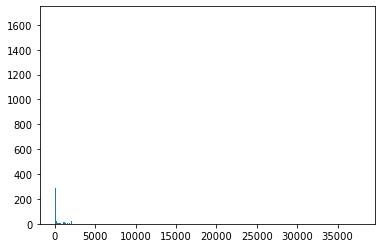

In [132]:
plt.hist([idx2sizediff[i] for i in idx], bins = 1000)
plt.show()

In [135]:
[i for i in idx if idx2sizediff[i] == 37689]

['CCCCCCCCCCCCCCCC(=O)OC[C@H](COP(=O)(O)OC[C@@H](O)CO)OC(=O)CCCCCCCCCCCCCCC.CCCCCCCCCCCCCCCC(=O)OC[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2ccc(N)nc2=O)C(O)[C@H]1O)OC(=O)CCCCCCCCCCCCCCC>>2.7.8.41']

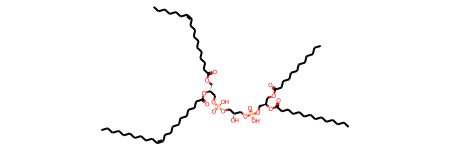

In [138]:
Chem.MolFromSmiles(list(rxn2prod['CCCCCCCCCCCCCCCC(=O)OC[C@H](COP(=O)(O)OC[C@@H](O)CO)OC(=O)CCCCCCCCCCCCCCC.CCCCCCCCCCCCCCCC(=O)OC[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2ccc(N)nc2=O)C(O)[C@H]1O)OC(=O)CCCCCCCCCCCCCCC>>2.7.8.41'])[0])

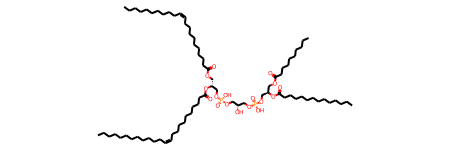

In [139]:
Chem.MolFromSmiles(list(rxn2prod['CCCCCCCCCCCCCCCC(=O)OC[C@H](COP(=O)(O)OC[C@@H](O)CO)OC(=O)CCCCCCCCCCCCCCC.CCCCCCCCCCCCCCCC(=O)OC[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2ccc(N)nc2=O)C(O)[C@H]1O)OC(=O)CCCCCCCCCCCCCCC>>2.7.8.41'])[1])

In [62]:
[d['reactants'] for d in data if d['ec'] == '1.4.1.4'][0]

['N',
 'NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1',
 'O=C([O-])CCC(=O)C(=O)[O-]',
 '[H+]']

In [38]:
set([d['products'][0] for d in data if d['ec'] == '1.4.1.4'])

{'*C(=O)C(=O)O',
 '*C(=O)C(=O)[O-]',
 'CC(C)[C@H](N)C(=O)O',
 'CCCC(=O)C(=O)[O-]',
 'N[C@@H](CCC(=O)O)C(=O)O',
 'N[C@@H](CCC(=O)[O-])C(=O)[O-]',
 'O=C([O-])CCC(=O)C(=O)[O-]',
 '[NH3+][C@@H](CCC(=O)[O-])C(=O)[O-]'}

In [ ]:
r_gt_p = []
for d in data:
    if d['split'] != 'test':
        continue
    reactants = [Chem.MolFromSmiles(m).GetNumAtoms() for m in d['reactants']]
    products = [Chem.MolFromSmiles(m).GetNumAtoms() for m in d['products']]
    
    r_gt_p.append(sum(reactants) >= sum(products))
    # if sum(reactants) < sum(products):
    #     break

In [333]:
len(data)

62222

In [340]:
reactants2products = defaultdict(set)
for d in tqdm(data):
    rx = '.'.join(sorted(d['reactants'])) + '>>' + d['ec']
    reactants2products[rx].add(d['products'][0])
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62222/62222 [00:01<00:00, 49446.62it/s]


In [341]:
len(reactants2products)

52753

In [125]:
sizes = []
for d in tqdm(data):
    rs = Chem.MolFromSmiles('.'.join(d['reactants']))
    ps = Chem.MolFromSmiles('.'.join(d['products']))
    sizes.append((rs.GetNumAtoms(), ps.GetNumAtoms()))


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62222/62222 [00:38<00:00, 1631.74it/s]


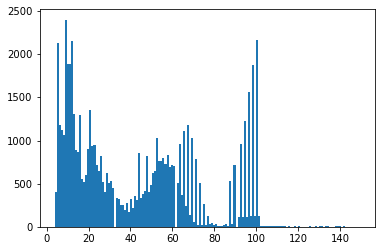

In [144]:
plt.hist([s[1] for s in sizes if s[1] < 150], bins = 150)
plt.show()

In [146]:
np.percentile([s[1] for s in sizes], 50)

38.0

In [191]:
data[0]

{'reactants': ['NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1',
  'NCCC=O',
  'O'],
 'products': ['NCCC(=O)O'],
 'ec': '1.2.1.8',
 'split': 'train',
 'from': '/Mounts/rbg-storage1/datasets/Enzymes/ECReact/ibm_splits/experiments/4/tgt-train.txt',
 'rxnid': 'train_0'}

In [193]:
mol = get_mols(data[0]['products'])[0]

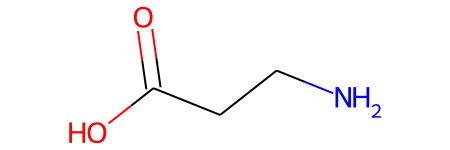

In [192]:
mol

In [195]:
get_size([mol])

6

In [224]:
protein2substrate = defaultdict(set)
for rowid, reaction in tqdm(enumerate(data), total=len(data)):
    reactants = get_mols(reaction["reactants"])
    reactants = [Chem.MolToSmiles(r) for r in reactants]
    ec = reaction["ec"]
    if ec not in ec2uniprot:
        continue
    for rid, reactant in enumerate(reactants):
        unis = ec2uniprot[ec]
        for u in unis:
            protein2substrate[u].add(reactant)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62222/62222 [00:42<00:00, 1450.56it/s]


In [225]:
len(protein2substrate)

201147

In [226]:
lens = [len(v) for k,v in protein2substrate.items()  ]

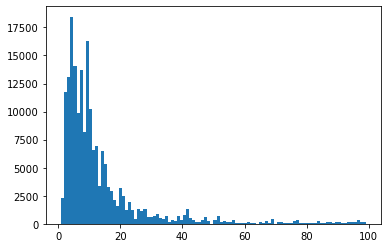

In [342]:
plt.hist([l for l in lens if l < 100 ], bins = 100)
plt.show()

In [278]:
np.percentile(lens, 99)

435.0

In [279]:
[k for k,v in protein2substrate.items() if len(v) == 435 ]

['Q9AIX6',
 'Q9AIX7',
 'P86491',
 'Q88FY2',
 'A0A0H3LKL4',
 'Q3S8R0',
 'P20839-1',
 'P20839-6',
 'P20839-3',
 'P20839-5',
 'P20839-4',
 'P20839-2',
 'P20839',
 'P12268',
 'P20839-7',
 'C1I201',
 'Q06136-2',
 'Q06136-1',
 'Q06136',
 'B5B0J6',
 'Q6F6Y2',
 'A1TFU9',
 'B6D1N4',
 'Q8PDQ6',
 'A6T923',
 'O52379',
 'O52380',
 'Q7X281',
 'Q9I0Q0',
 'Q02N79',
 'A0A0E4AFH6',
 'B1MFK1',
 'P27138',
 'F1QH17',
 'P21637',
 'Q86BA1-3',
 'Q86BA1-4',
 'Q86BA1',
 'F1QWK4',
 'Q86BA1-5',
 'F1MF74',
 'C0LTM1',
 'Q86BA1-2',
 'F6QZ15',
 'Q86BA1-1',
 'P04180']

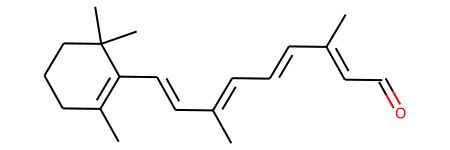

In [300]:
Chem.MolFromSmiles(list(protein2substrate['P12268'])[0])

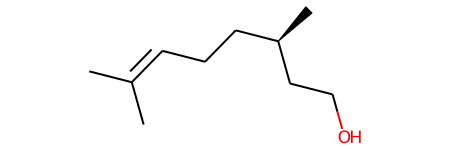

In [331]:
Chem.MolFromSmiles(list(protein2substrate['P12268'])[144])

In [332]:
mol = Chem.MolFromSmiles(list(protein2substrate['P12268'])[144])
Chem.Draw.MolToFile(mol, "P12268_mol4.png", (512,512))

In [337]:
allsubss = set([s for k,v in protein2substrate.items() for s in v])

In [338]:
len(allsubss)

19196

In [343]:
# look at brenda

### Brenda

In [446]:
def from_smiles(smiles: str, with_hydrogen: bool = False, kekulize: bool = False):
    r"""Converts a SMILES string to a :class:`torch_geometric.data.Data`
    instance.
    Args:
        smiles (string, optional): The SMILES string.
        with_hydrogen (bool, optional): If set to :obj:`True`, will store
            hydrogens in the molecule graph. (default: :obj:`False`)
        kekulize (bool, optional): If set to :obj:`True`, converts aromatic
            bonds to single/double bonds. (default: :obj:`False`)
    """

    RDLogger.DisableLog("rdApp.*")

    mol = Chem.MolFromSmiles(smiles, sanitize=False)

    if mol is None:
        mol = Chem.MolFromSmiles("")
    if with_hydrogen:
        mol = Chem.AddHs(mol)
    if kekulize:
        mol = Chem.Kekulize(mol)

    xs = []
    for atom in mol.GetAtoms():
        x = []
        x.append(x_map["atomic_num"].index(atom.GetAtomicNum()))
        x.append(x_map["chirality"].index(str(atom.GetChiralTag())))
        # x.append(x_map["degree"].index(atom.GetTotalDegree()))
        x.append(x_map["formal_charge"].index(atom.GetFormalCharge()))
        # x.append(x_map["num_hs"].index(atom.GetTotalNumHs()))
        x.append(x_map["num_radical_electrons"].index(atom.GetNumRadicalElectrons()))
        x.append(x_map["hybridization"].index(str(atom.GetHybridization())))
        x.append(x_map["is_aromatic"].index(atom.GetIsAromatic()))
        x.append(x_map["is_in_ring"].index(atom.IsInRing()))
        xs.append(x)

    x = torch.tensor(xs, dtype=torch.long).view(-1, 9)

    edge_indices, edge_attrs = [], []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        e = []
        e.append(e_map["bond_type"].index(str(bond.GetBondType())))
        e.append(e_map["stereo"].index(str(bond.GetStereo())))
        e.append(e_map["is_conjugated"].index(bond.GetIsConjugated()))

        edge_indices += [[i, j], [j, i]]
        edge_attrs += [e, e]

    edge_index = torch.tensor(edge_indices)
    edge_index = edge_index.t().to(torch.long).view(2, -1)
    edge_attr = torch.tensor(edge_attrs, dtype=torch.long).view(-1, 3)

    if edge_index.numel() > 0:  # Sort indices.
        perm = (edge_index[0] * x.size(0) + edge_index[1]).argsort()
        edge_index, edge_attr = edge_index[:, perm], edge_attr[perm]

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, smiles=smiles)

In [386]:
len(brenda['data'])

7754

In [353]:
j=0
reaction_keys = set()
for ec, ec_dict in brenda['data'].items():
    if "proteins" not in ec_dict:
        continue
    proteinid2uniprot = {
                k: v[0]["accessions"] for k, v in ec_dict["proteins"].items()
            }
    reaction_keys.update([k for k in ec_dict if "reaction" in k])

In [354]:
reaction_keys

{'generic_reaction', 'natural_reaction', 'reaction'}

In [387]:
uniprot2reactions = defaultdict(set)
allproteins = set()
allreactions = set()
for ec, ec_dict in brenda['data'].items():
    if "proteins" not in ec_dict:
        continue
    proteinid2uniprot = {
                k: list(set([u for  u in acc["accessions"]])) for k, v in ec_dict["proteins"].items() for acc in v 
            }
    proteinid2uniprot = {
                k: v[0]["accessions"] for k, v in ec_dict["proteins"].items()
            }
    
    for k, v in ec_dict["proteins"].items():
        for acc in v:
            for u in acc["accessions"]:
                allproteins.add(u)
    
    for reaction_key in ["reaction", "natural_reaction"]:
        if reaction_key in ec_dict:
            for entry in ec_dict[reaction_key]:
                # check both produces and reactants defined
                if ("educts" in entry) and ("products" in entry):
                    # sort to check if reaction exists already
                    rs = sorted(entry["educts"])
                    ps = sorted(entry["products"])
                    reaction_string = ".".join(rs) + ">>" + ".".join(ps) + f"|{ec}"
                    allreactions.add(reaction_string)
                    for protein in entry.get("proteins", []):
                        if proteinid2uniprot.get(protein, False):
                            uniprots = proteinid2uniprot[protein]
                            for uniprotid in uniprots:
                                uniprot2reactions[uniprotid].add(reaction_string)
                                

In [390]:
allreactions = list(allreactions)

In [541]:
sizes = []
type_error = []
for i, rxn in tqdm(enumerate(allreactions), ncols=60, total = len(allreactions)):
    rs, ps = rxn.split("|")[0].split(">>")
    rs = rs.split(".")
    ps = ps.split(".")
    
    # check if sample has mol
    if any(s in [None, [], "?"] for s in (rs + ps)):
        continue 
    
    rs = [get_smiles(r) for r in rs]
    ps = [get_smiles(r) for r in ps]
    
    # check if sample has mol
    if any(s in [None, [], "?"] for s in (rs + ps)):
        continue 
    
    rs = Chem.MolFromSmiles('.'.join(rs), sanitize=False)
    ps = Chem.MolFromSmiles('.'.join(ps), sanitize=False)
    sizes.append((rs.GetNumAtoms(), ps.GetNumAtoms(), i))
    
    pset = get_syms([ps])
    if 'H' in pset:
        pset.remove('H')
    if not pset.issubset(get_syms([rs])):
        type_error.append(i)

100%|█████████████| 123309/123309 [00:27<00:00, 4558.77it/s]


(13, 13)

In [496]:
len(type_error)

103

In [531]:
len(sizes)

46407

In [532]:
103/46407

0.002219492748938738

In [491]:
s = get_syms([ps])

In [492]:
s.remove('H')

In [493]:
s

{'C', 'N', 'O'}

In [469]:
len(sizes)

46407

In [522]:
type_error[3]

7460

In [523]:
rxn = allreactions[7460]

In [524]:
rxn

'H2O.p-nitrophenyl-soman>>p-nitrophenol.soman|3.1.8.2'

In [525]:
rs, ps = rxn.split("|")[0].split(">>")
rs = rs.split(".")
ps = ps.split(".")

In [526]:
rs = [get_smiles(r) for r in rs]
ps = [get_smiles(r) for r in ps]

rs = Chem.MolFromSmiles('.'.join(rs), sanitize=False)
ps = Chem.MolFromSmiles('.'.join(ps), sanitize=False)

In [527]:
get_syms([ps])

{'C', 'F', 'N', 'O', 'P'}

In [528]:
get_syms([rs])

{'C', 'H', 'N', 'O', 'P'}

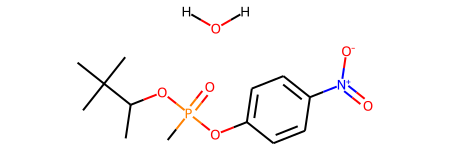

In [529]:
rs

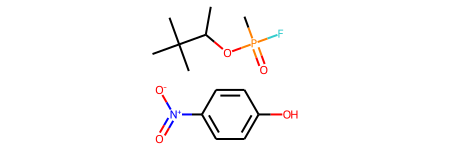

In [530]:
ps

In [432]:
mol = Chem.MolFromSmiles(get_smiles('Zn protoporphyrin IX'), sanitize=False )

In [447]:
mol.GetNumAtoms()

43

In [449]:
get_syms([mol])

{'C', 'N', 'O', 'Zn'}

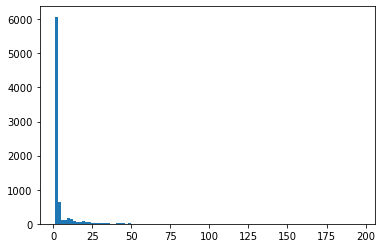

In [539]:
plt.hist([j-i for i,j in sizes if j-i>0], bins = 100)
plt.show()

In [540]:
Counter([j-i for i,j in sizes if j-i >0]).most_common(10)

[(1, 4104),
 (2, 1971),
 (3, 444),
 (4, 181),
 (9, 99),
 (10, 78),
 (5, 72),
 (12, 66),
 (11, 66),
 (7, 62)]

In [544]:
[k for i,j,k in sizes if j-i>1][0]

48

In [622]:
rxn = allreactions[48]

In [623]:
rxn

'rac-2-chloro-phenylalanine>>2-chloro-D-beta-phenylalanine.2-chloro-L-beta-phenylalanine|5.4.3.11'

In [571]:
list(CHEBI_DB.keys())[0]

'CHEBI:90'

In [572]:
CHEBI_DB['CHEBI:90']

{'ChEBI ID': 'CHEBI:90',
 'ChEBI Name': '(-)-epicatechin',
 'Star': '3',
 'Definition': 'A catechin with (2R,3R)-configuration.',
 'Secondary ChEBI ID': 'CHEBI:18484',
 'InChI': 'InChI=1S/C15H14O6/c16-8-4-11(18)9-6-13(20)15(21-14(9)5-8)7-1-2-10(17)12(19)3-7/h1-5,13,15-20H,6H2/t13-,15-/m1/s1',
 'InChIKey': 'PFTAWBLQPZVEMU-UKRRQHHQSA-N',
 'SMILES': '[H][C@@]1(Oc2cc(O)cc(O)c2C[C@H]1O)c1ccc(O)c(O)c1',
 'Formulae': 'C15H14O6',
 'Charge': '0',
 'Mass': '290.26810',
 'Monoisotopic Mass': '290.07904',
 'IUPAC Names': '(2R,3R)-2-(3,4-dihydroxyphenyl)-3,4-dihydro-2H-chromene-3,5,7-triol',
 'Synonyms': '(-)-Epicatechin',
 'CAS Registry Numbers': '490-46-0',
 'KEGG COMPOUND Database Links': 'C09727',
 'KNApSAcK Database Links': 'C00000956',
 'LINCS Database Links': 'LSM-20956',
 'LIPID MAPS instance Database Links': 'LMPK12020003',
 'MetaCyc Database Links': 'CPD-7630',
 'PubMed citation Links': ['7655336', '10427682'],
 'Reaxys Registry Numbers': '92760',
 'ACToR Database Links': '2545-08-6',
 'B

In [569]:
brenda_smiles['2-chloro-D-beta-phenylalanine']

{'brenda_id': '228891',
 'inchi': 'NXXFYRJVRISCCP-MRVPVSSYSA-N',
 'name': '2-chloro-D-beta-phenylalanine',
 'pubchem_link': 'http://www.ncbi.nlm.nih.gov/sites/entrez?cmd=search&db=pccompound&term=NXXFYRJVRISCCP-MRVPVSSYSA-N',
 'pubchem_data': [{'CID': 737973,
   'CanonicalSMILES': 'C1=CC=C(C(=C1)C(CC(=O)O)N)Cl',
   'IsomericSMILES': 'C1=CC=C(C(=C1)[C@@H](CC(=O)O)N)Cl',
   'InChI': 'InChI=1S/C9H10ClNO2/c10-7-4-2-1-3-6(7)8(11)5-9(12)13/h1-4,8H,5,11H2,(H,12,13)/t8-/m1/s1',
   'InChIKey': 'NXXFYRJVRISCCP-MRVPVSSYSA-N'},
  {'CID': 6934105,
   'CanonicalSMILES': 'C1=CC=C(C(=C1)C(CC(=O)[O-])[NH3+])Cl',
   'IsomericSMILES': 'C1=CC=C(C(=C1)[C@@H](CC(=O)[O-])[NH3+])Cl',
   'InChI': 'InChI=1S/C9H10ClNO2/c10-7-4-2-1-3-6(7)8(11)5-9(12)13/h1-4,8H,5,11H2,(H,12,13)/t8-/m1/s1',
   'InChIKey': 'NXXFYRJVRISCCP-MRVPVSSYSA-N'}]}

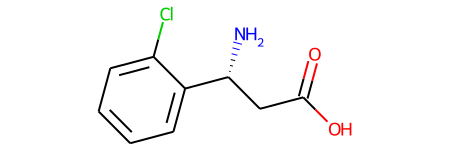

In [564]:
Chem.MolFromSmiles('C1=CC=C(C(=C1)[C@@H](CC(=O)O)N)Cl')

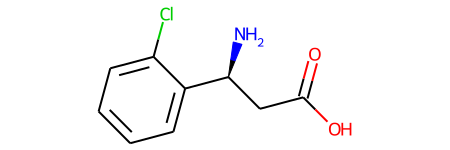

In [566]:
Chem.MolFromSmiles('C1=CC=C(C(=C1)[C@H](CC(=O)O)N)Cl')

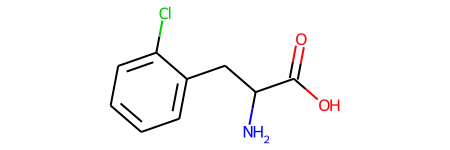

In [568]:
Chem.MolFromSmiles('C1=CC=C(C(=C1)CC(C(=O)O)N)Cl')

In [643]:
rs, ps = rxn.split("|")[0].split(">>")
rs = rs.split(".")
ps = ps.split(".")

In [644]:
[get_smiles(r) for r in ps]

['C1=CC=C(C(=C1)C(CC(=O)O)N)Cl', 'C1=CC=C(C(=C1)C(CC(=O)O)N)Cl']

In [629]:
rs = [get_smiles(r) for r in rs]
ps = [get_smiles(r) for r in ps]

In [621]:
rs = Chem.MolFromSmiles('.'.join(rs), sanitize=False)
ps = Chem.MolFromSmiles('.'.join(ps), sanitize=False)

['rac-2-chloro-phenylalanine']

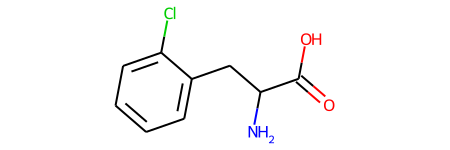

In [627]:
rs

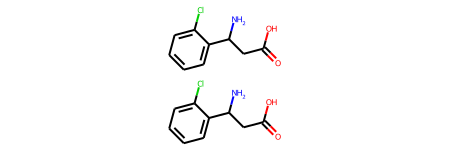

In [552]:
ps

In [574]:
line = '[CH2:15]([CH:16]([CH3:17])[CH3:18])[Mg+:19].[CH2:20]1[O:21][CH2:22][CH2:23][CH2:24]1.[Cl-:14].[OH:1][c:2]1[n:3][cH:4][c:5]([C:6](=[O:7])[N:8]([O:9][CH3:10])[CH3:11])[cH:12][cH:13]1>>[OH:1][c:2]1[n:3][cH:4][c:5]([C:6](=[O:7])[CH2:15][CH:16]([CH3:17])[CH3:18])[cH:12][cH:13]1 15-19;6-15;6-8'

In [575]:
rxn_smi = line.strip().split(' ')[0]

In [576]:
rxn_smi

'[CH2:15]([CH:16]([CH3:17])[CH3:18])[Mg+:19].[CH2:20]1[O:21][CH2:22][CH2:23][CH2:24]1.[Cl-:14].[OH:1][c:2]1[n:3][cH:4][c:5]([C:6](=[O:7])[N:8]([O:9][CH3:10])[CH3:11])[cH:12][cH:13]1>>[OH:1][c:2]1[n:3][cH:4][c:5]([C:6](=[O:7])[CH2:15][CH:16]([CH3:17])[CH3:18])[cH:12][cH:13]1'

In [577]:
reactants = Chem.MolFromSmiles(rxn_smi.split('>')[0])
products  = Chem.MolFromSmiles(rxn_smi.split('>')[2])


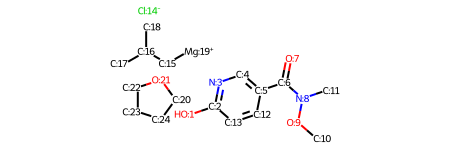

In [578]:
reactants

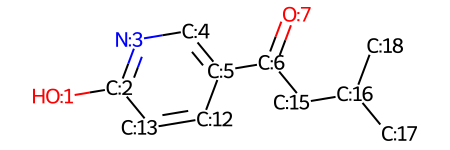

In [579]:
products

In [580]:
conserved_maps = [a.GetProp('molAtomMapNumber') for a in products.GetAtoms() if a.HasProp('molAtomMapNumber')]

In [ ]:


bond_changes = set() # keep track of bond changes

# Look at changed bonds
bonds_prev = {}
for bond in reactants.GetBonds():
    nums = sorted(
        [bond.GetBeginAtom().GetProp('molAtomMapNumber'),
         bond.GetEndAtom().GetProp('molAtomMapNumber')])
    if (nums[0] not in conserved_maps) and (nums[1] not in conserved_maps): continue
    bonds_prev['{}~{}'.format(nums[0], nums[1])] = bond.GetBondTypeAsDouble()
    
bonds_new = {}
for bond in products.GetBonds():
    nums = sorted(
        [bond.GetBeginAtom().GetProp('molAtomMapNumber'),
         bond.GetEndAtom().GetProp('molAtomMapNumber')])
    bonds_new['{}~{}'.format(nums[0], nums[1])] = bond.GetBondTypeAsDouble()


for bond in bonds_prev:
    if bond not in bonds_new:
        bond_changes.add((bond.split('~')[0], bond.split('~')[1], 0.0)) # lost bond
    else:
        if bonds_prev[bond] != bonds_new[bond]:
            bond_changes.add((bond.split('~')[0], bond.split('~')[1], bonds_new[bond])) # changed bond
for bond in bonds_new:
    if bond not in bonds_prev:
        bond_changes.add((bond.split('~')[0], bond.split('~')[1], bonds_new[bond]))  # new bond

In [581]:
data = json.load(open('/Mounts/rbg-storage1/datasets/Enzymes/MCSA/entries.json', 'r'))

In [593]:
[len(d['roles']) for d in data[0]['residues']]

[8, 6, 6, 8, 5, 9]

In [600]:
[d['residue_sequences'][0]['code'] for d in  data[0]['residues']]

['Asp', 'Ser', 'Cys', 'Cys', 'His', 'Glu']

In [601]:
data[0]['residues'][-2]

{'mcsa_id': 1,
 'roles_summary': 'electrostatic stabiliser, hydrogen bond donor',
 'function_location_abv': '',
 'ptm': '',
 'roles': [{'group_function': '',
   'function_type': 'interaction',
   'function': 'hydrogen bond donor',
   'emo': 'EMO_00114'},
  {'group_function': '',
   'function_type': 'interaction',
   'function': 'hydrogen bond donor',
   'emo': 'EMO_00114'},
  {'group_function': '',
   'function_type': 'interaction',
   'function': 'hydrogen bond donor',
   'emo': 'EMO_00114'},
  {'group_function': '',
   'function_type': 'interaction',
   'function': 'hydrogen bond donor',
   'emo': 'EMO_00114'},
  {'group_function': 'electrostatic interaction',
   'function_type': 'spectator',
   'function': 'electrostatic stabiliser',
   'emo': 'EMO_00033'}],
 'residue_chains': [{'chain_name': 'A',
   'pdb_id': '1b73',
   'assembly_chain_name': 'A',
   'assembly': 1,
   'code': 'His',
   'resid': 180,
   'auth_resid': 180,
   'is_reference': True,
   'domain_name': 'A02',
   'domain_

In [6]:
from indigo import *

In [7]:
indigo = Indigo()

In [607]:
rxnsmi1='[NH2:1][CH:6]([CH2:5][CH2:4][S-])[C:7]([OH:2])=[O:3].[NH2:1][CH:6]([CH2:5][CH2:4][S])[C:7]([OH:2])=[O:3]'

In [657]:
rxnsmi2 ='CCOC(=O)C(=C)O[Si](C)(C)C.COC1=CC=C(Br)C=C1C(C)(C)O>>CCOC(=O)C(=O)CC(C)(C)C1=CC(Br)=CC=C1OC'

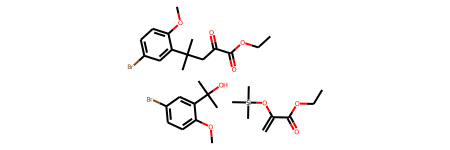

In [658]:
Chem.MolFromSmiles(rxnsmi2)

In [8]:
def addmapbyINDIGO(rxnsmi):
    smi = rxnsmi
    rxn = indigo.loadReaction(smi)
    rxn.automap('discard ignore_charges ignore_isotopes ignore_valence ignore_radicals')
    rxn.automap('discard')
    rxnsmi_map_indigo = rxn.smiles() 
    return rxnsmi_map_indigo

In [4]:
brxn = f"{'.'.join(rs)}>>{'.'.join(ps)}"

NameError: name 'rs' is not defined

In [2]:
brxn_anot = addmapbyINDIGO(rxnsmi2)

NameError: name 'addmapbyINDIGO' is not defined

In [1]:
brxn_anot

NameError: name 'brxn_anot' is not defined

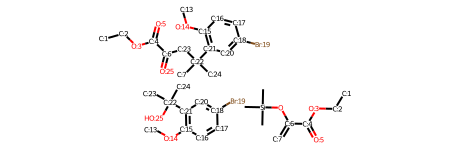

In [650]:
Chem.MolFromSmiles('.'.join(brxsn_anot.split('>>')))

In [640]:
brxn_anot.split('>>')[0]

'[CH:1]1[CH:6]=[C:5]([CH2:7][CH:8]([NH2:12])[C:9]([OH:11])=[O:10])[C:4]([Cl:13])=[CH:3][CH:2]=1'

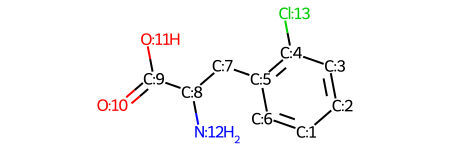

In [641]:
Chem.MolFromSmiles(brxn_anot.split('>>')[0])

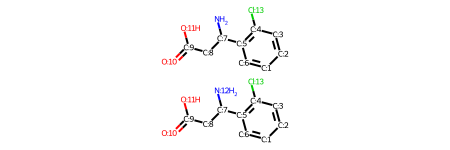

In [642]:
Chem.MolFromSmiles(brxn_anot.split('>>')[1])

In [659]:
s = '[CH3:26][c:27]1[cH:28][cH:29][cH:30][cH:31][cH:32]1.[Cl:18][C:19](=[O:20])[O:21][C:22]([Cl:23])([Cl:24])[Cl:25].[NH2:1][c:2]1[cH:3][cH:4][c:5]([Br:17])[c:6]2[c:10]1[O:9][C:8]([CH3:11])([C:12](=[O:13])[O:14][CH2:15][CH3:16])[CH2:7]2'

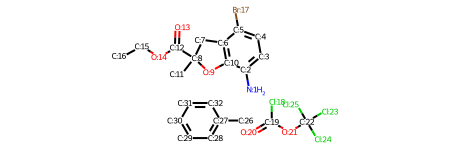

In [660]:
Chem.MolFromSmiles(s)

In [9]:
rxn = '*OP(=O)([O-])OC[C@H]1O[C@@H](n2ccc(N)nc2=O)[C@H](O)[C@@H]1OP(=O)([O-])OC[C@H]1O[C@@H](n2ccc(N)nc2=O)[C@H](O)[C@@H]1OP(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OC(=O)C[NH3+].CC(=O)N[C@H]1[C@H](O[C@@H]2[C@@H](CO)O[C@H](OP(=O)([O-])OP(=O)([O-])OC/C=C(/C)CC/C=C(/C)CC/C=C(/C)CC/C=C(/C)CC/C=C(/C)CC/C=C(/C)CC/C=C(/C)CC/C=C(/C)CC/C=C(\\C)CC/C=C(\\C)CCC=C(C)C)[C@H](NC(C)=O)[C@H]2O[C@H](C)C(=O)N[C@@H](C)C(=O)N[C@H](CCC(=O)N[C@@H](CCCCNC(=O)C[NH3+])C(=O)N[C@H](C)C(=O)N[C@H](C)C(=O)[O-])C(N)=O)O[C@H](CO)[C@@H](O)[C@@H]1O>>CC(=O)N[C@H]1[C@H](O[C@@H]2[C@@H](CO)O[C@H](OP(=O)([O-])OP(=O)([O-])OC/C=C(/C)CC/C=C(/C)CC/C=C(/C)CC/C=C(/C)CC/C=C(/C)CC/C=C(/C)CC/C=C(/C)CC/C=C(/C)CC/C=C(\\C)CC/C=C(\\C)CCC=C(C)C)[C@H](NC(C)=O)[C@H]2O[C@H](C)C(=O)N[C@@H](C)C(=O)N[C@H](CCC(=O)N[C@@H](CCCCNC(=O)CNC(=O)CNC(=O)C[NH3+])C(=O)N[C@H](C)C(=O)N[C@H](C)C(=O)[O-])C(N)=O)O[C@H](CO)[C@@H](O)[C@@H]1O'

In [12]:
Chem.MolFromSmiles(rxn.split('>>')[0]).GetNumAtoms()

202

In [13]:
Chem.MolFromSmiles(rxn.split('>>')[1]).GetNumAtoms()

142

In [16]:
with open('/Mounts/rbg-storage1/users/pgmikhael/rexgen_direct/rexgen_direct/core_wln_global/pgm_test/ecreact.cbond_detailed') as g: 
    lines = g.readlines()
[i for i,l in enumerate(lines) if 'INVALID' in l]

[2561, 2563, 2711, 2730, 2753]

In [27]:
with open('/Mounts/rbg-storage1/users/pgmikhael/rexgen_direct/rexgen_direct/ecreact/test.txt', 'r') as f, open('/Mounts/rbg-storage1/users/pgmikhael/rexgen_direct/rexgen_direct/ecreact/test_for_eval.txt', 'w') as g:
    lines = f.readlines()
    for i,l in enumerate(lines):
        if not (i in [2561, 2563, 2711, 2730, 2753]):
            g.write(l)
            

In [ ]:
with open('/Mounts/rbg-storage1/users/pgmikhael/rexgen_direct/rexgen_direct/ecreact/test.txt') as f:
    lines = f.readlines()
    for i in [2561, 2563, 2711, 2730, 2753]:
        print(lines[i])

In [23]:
[p for p in data if "*[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])OP(=O)([O-])O)[C@@H](O)[C@H]1*" in p['products'][0]] 

[{'reactants': ['O'],
  'products': ['*[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])OP(=O)([O-])O)[C@@H](O)[C@H]1*'],
  'ec': '3.1.13.2',
  'split': 'test',
  'from': '/Mounts/rbg-storage1/datasets/Enzymes/ECReact/ibm_splits/experiments/4/tgt-train.txt',
  'rxnid': 'test_2561'}]

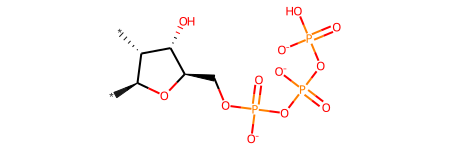

In [26]:
Chem.MolFromSmiles('*[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])OP(=O)([O-])O)[C@@H](O)[C@H]1*')

In [ ]:
with open('/Mounts/rbg-storage1/users/pgmikhael/rexgen_direct/rexgen_direct/core_wln_global/pgm_test/ecreact.cbond_detailed') as g: 
    lines = g.readlines()
[i for i,l in enumerate(lines) if 'INVALID' in l]

In [30]:
import pickle
from tqdm import tqdm 

In [ ]:
predictions = pickle.load(open('/Mounts/rbg-storage1/users/pgmikhael/rexgen_direct/rexgen_direct/rank_diff_wln/pgm_test/ecreact.cbond_detailed_backup.p', 'rb'))

In [ ]:
topK = 11
n = 0
correct = {rk+1: 0 for rk in range(topK)}
for i, preds in tqdm(enumerate(predictions), total = len(predictions), ncols= 60):
    if preds == "INVALID":
        continue 
    gold = test[i].strip("\n").split(">>")[-1]
    try:
        g_smile = Chem.MolToSmiles(Chem.MolFromSmiles(gold))
    except:
        continue
    
    for rk, rk_smiles in enumerate(preds[:topK]):
        p_smiles = []
        for smi in rk_smiles['smiles']:
            try:
                p_smiles.append(Chem.MolToSmiles(Chem.MolFromSmiles(smi)))
            except:
                continue
    
    
        if g_smile in set(p_smiles):
            correct[rk+1] += 1

    n += 1
    

In [ ]:
[v for i,v in correct.items() ]

In [ ]:
correct / n

In [ ]:
CN1C2CCC1CC(=O)C2
CN1C2CCC1CC(O)C2
CN1C2CCC1CC(O)C2